In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:

import os
import sys
import json

import argparse

from dataclasses import dataclass

In [55]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [56]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [57]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [58]:

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridCoarse,
    GridRefine,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


## Some user options

In [59]:
# TODO(hzh): use Ali's algorithm
Ali_way = False


In [60]:
# use yaml or csv input file
use_yaml = True


In [61]:

# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

case_type = 'smeaheia_v2'

In [62]:
# where test data located
data_path = '../'

## Examples

In [63]:

# # Examples
# The following are the test examples.

# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v1'),
            'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v2'), 
            'simcase': r'TEMP-0'}
cosmo = {
        'well_input': r'GaP_input_Cosmo_v3.csv', 
        'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
        'sim_path': os.path.join(data_path, './test_data/examples/cosmo'), 
        'simcase': r'TEMP-0'}

examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}


In [64]:

@dataclass                # @dataclass(kw_only=True)
class Arguments:
    ali_way: bool
    use_yaml: bool
    case_type: str
    output_dir: str = '.'
    output_name: str = 'LEG_HIRES'
    plot: bool = True

In [65]:

args = Arguments(ali_way=Ali_way, use_yaml=use_yaml, case_type=case_type)

In [66]:


############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = args.ali_way

# use yaml or csv input file
use_yaml = args.use_yaml

# pick an example from given three options: 
#  i.e, smeaheia_v1, smeaheia_v2 and cosmo
case_type = args.case_type

# output
output_dir = args.output_dir
# LRG name 
LGR_NAME = args.output_name


In [67]:

############# 1. Selected case ####################

# the selected example for testing
case = examples[case_type]

# where the location for the input parameters and eclipse .EGRID and .INIT files
sim_path = case['sim_path']


## Load well configuration file

In [68]:

############ 2. Load well configuration file ###############

if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)


## Build well class

In [69]:

########### 3. build Well class ######################

# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )


In [70]:
# save WellClass file for pytest unit/integration testing
DEBUG_SAVE = False
if DEBUG_SAVE:
    # Note: have to use pickle to keep integer key as integer
    import pickle

    well_input_name = case['well_input_yaml'].replace('.yaml', '.pkl')
    well_dict_name = os.path.join(sim_path, well_input_name)
    
    with open(well_dict_name, 'wb') as pkl_file:
        pickle.dump(my_well.__dict__, pkl_file)

In [71]:

# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience

# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df

barriers_mod_df = well_df.barriers_mod_df


## Coarse, LGR and Refine grids

In [72]:

############### 4. various grids #####################

##### 4.1 grid_coarse 

# location of .egrid
simcase = os.path.join(sim_path, case['simcase'])

# Loading the model
grid_coarse = GridCoarse(simcase)

##### 4.2 LGR grid 

# LGR grid information in x, y, z directions
lgr = LGRBuilder(grid_coarse, 
                annulus_df, 
                drilling_df, casings_df, borehole_df,
                barriers_mod_df,
                Ali_way)

##### 4.3 grid_refine 

# Set up dataframe for LGR mesh
grid_refine = GridRefine(grid_coarse,
                        lgr.LGR_sizes_x, lgr.LGR_sizes_y, 
                        lgr.LGR_sizes_z, 
                        )


Minimimum grid size is 5.00 cm
nx=22, ny=22, nz=150


## Build LGR grids

In [73]:

############### 5. build LGR #####################

# set up permeability
grid_refine.build_LGR(drilling_df, casings_df, barriers_mod_df)


## Output .grdel file

In [74]:

########### 6. output grdecl file ###################

# Write LGR file
lgr.build_grdecl(output_dir, LGR_NAME,
                    drilling_df,
                    casings_df,
                    barriers_mod_df)


...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
====> top_rkb        float64
bottom_rkb       int64
diameter_in    float64
oh_perm          int64
diameter_m     float64
top_msl        float64
bottom_msl     float64
n_grd_id         int64
k_min            int64
k_max            int64
ij_min           int64
ij_max           int64
dtype: object
drilling===> 0 0.9144 3.0 18.0 10.0 15.0
drilling===> 1 0.4445 7.0 14.0 15.0 48.0
drilling===> 2 0.31115 8.0 13.0 48.0 94.0
drilling===> 3 0.21589999999999998 9.0 12.0 94.0 149.0
DEBUG ==============> handling open hole section
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/SCREEN/notebooks/LEG_HIRES.grdecl


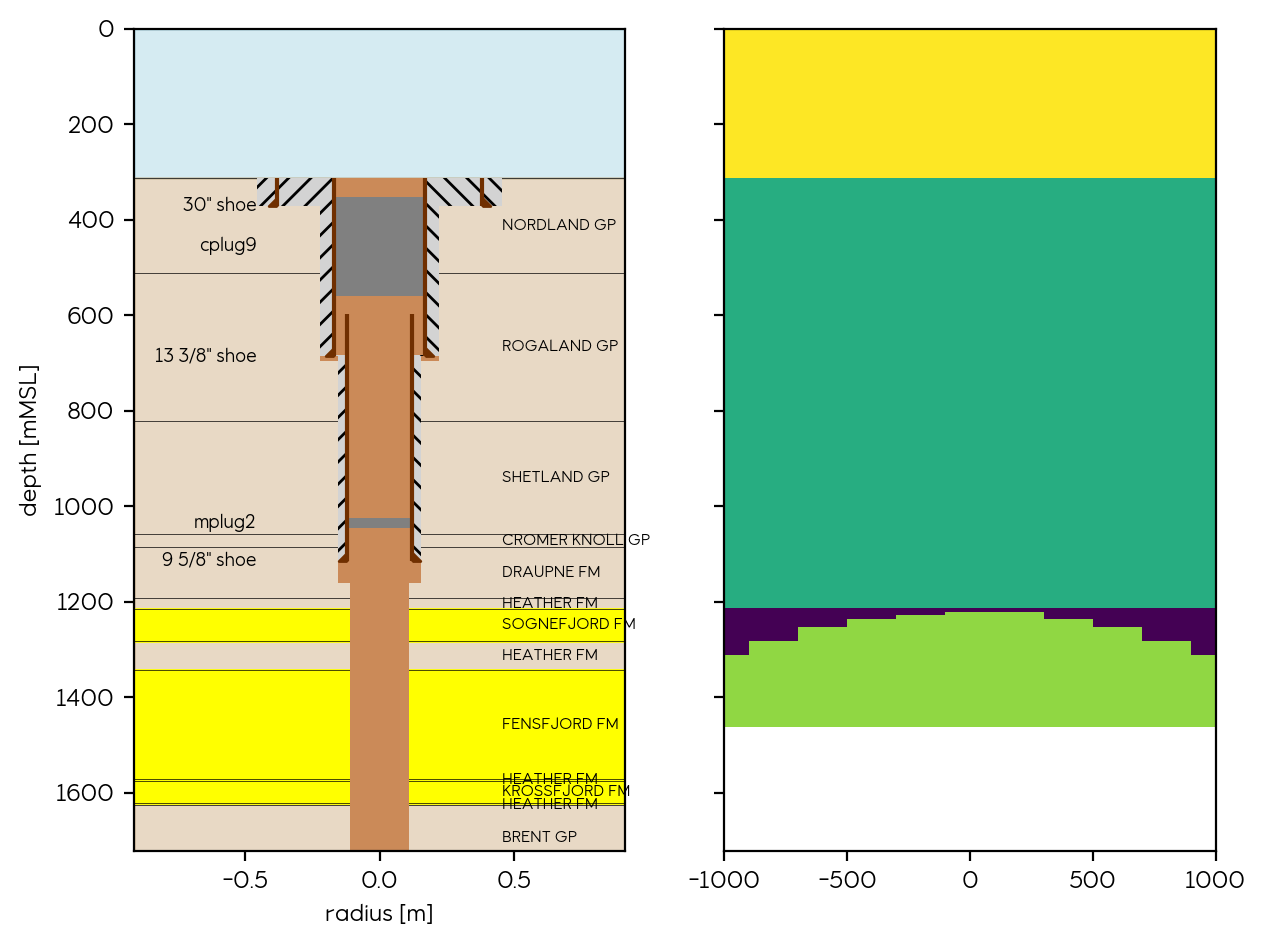

In [75]:

# for qc
if args.plot:
    plot_grid(my_well, grid_coarse)

    


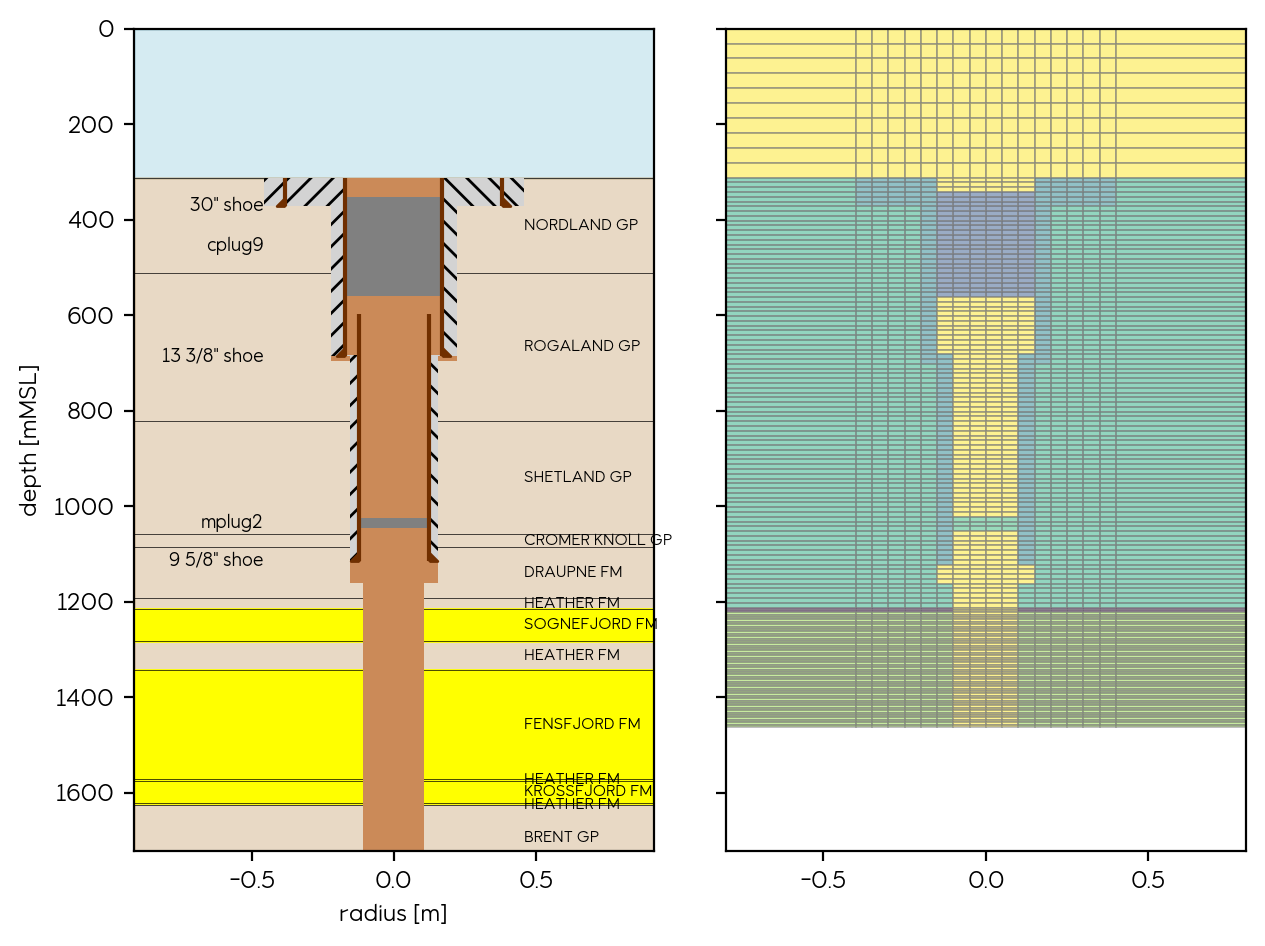

In [76]:
if args.plot:
    plot_grid(my_well, grid_refine)



## Compare output

Only when we are using 'smeaheia_v1' dataset and using Ali's grid logic

In [77]:
!ls -l LEG_HIRES.grdecl*

-rw-rw-r-- 1 hzh scs_ccs 5669 Oct 12 01:40 LEG_HIRES.grdecl
-rw-rw-r-- 1 hzh scs_ccs 5383 Sep 22 17:29 LEG_HIRES.grdecl.smeaheia


In [78]:
# check the results, only compare smeaheia_v1
if case_type == 'smeaheia_v1' and Ali_way:
    !diff LEG_HIRES.grdecl LEG_HIRES.grdecl.smeaheia